In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")

print("Path to dataset files:", path)

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 6.03M/6.03M [00:02<00:00, 2.69MB/s]

Extracting files...
Path to dataset files: C:\Users\ASUS\.cache\kagglehub\datasets\alexteboul\diabetes-health-indicators-dataset\versions\1


Dataset Shape: (253680, 22)
Missing values:
 Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64
Duplicated: 24206
   Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1              0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2              0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3              0.0     1.0       0.0        1.0  27.0     0.

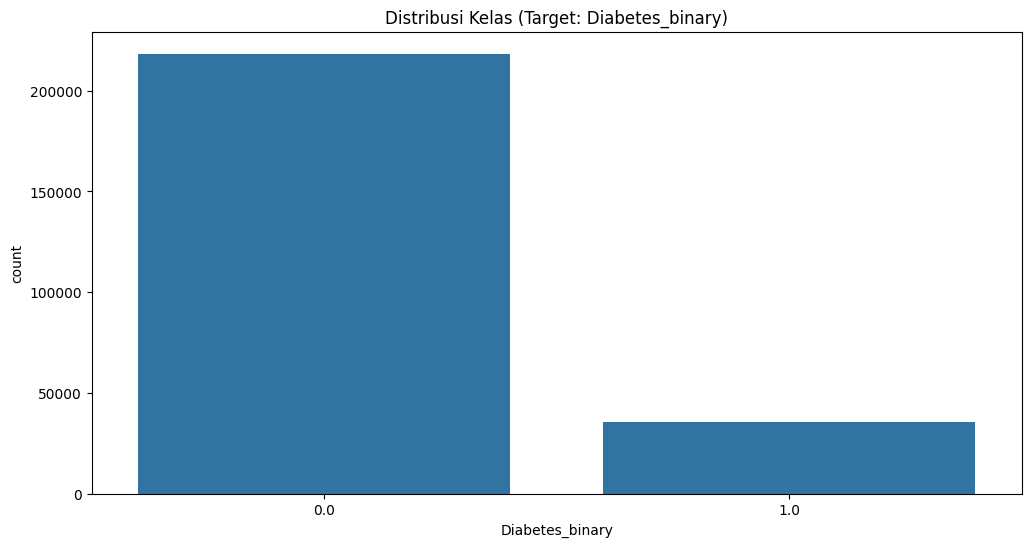

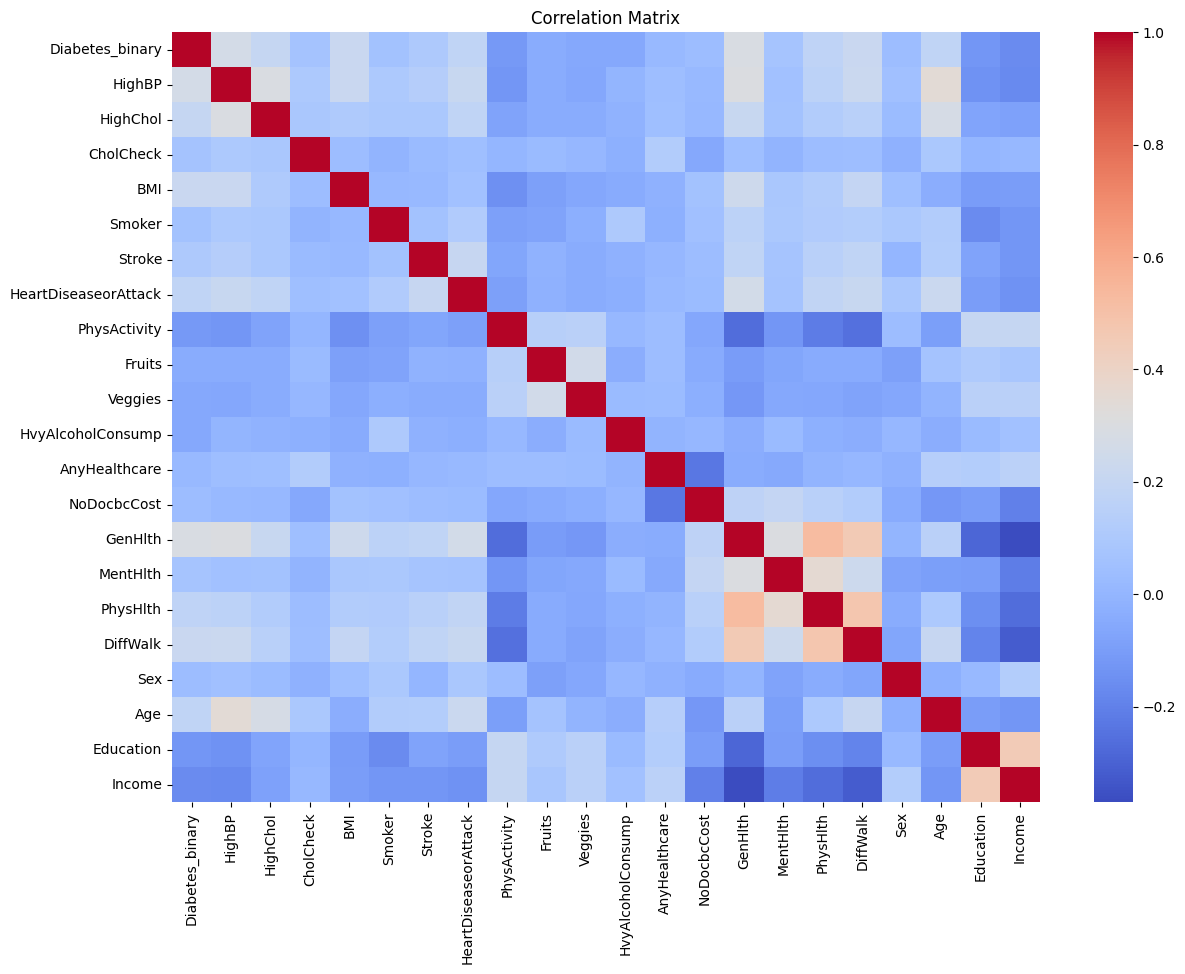

Before SMOTE: [174667  28277]
After SMOTE: [174667 174667]
Akurasi Logistic Regression: 0.7331086408073163
Akurasi Random Forest: 0.8488647114474929
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Akurasi XGBoost (Tuned): 0.8635879848628193
Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}

=== Evaluasi XGBoost ===
[[42375  1292]
 [ 5629  1440]]
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     43667
         1.0       0.53      0.20      0.29      7069

    accuracy                           0.86     50736
   macro avg       0.70      0.59      0.61     50736
weighted avg       0.83      0.86      0.84     50736



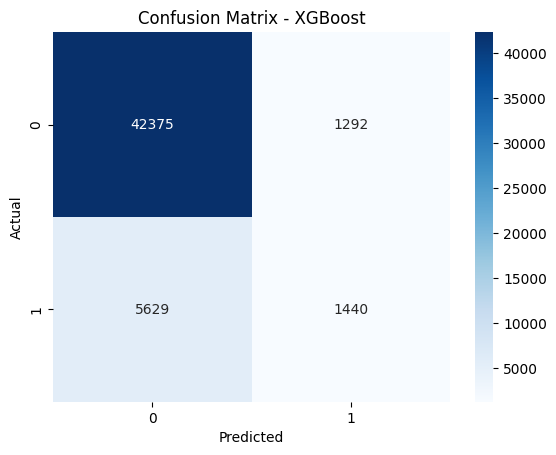


=== Kesimpulan ===
✓ Akurasi ≥ 85% — Syarat tugas terpenuhi!


In [2]:
# FINAL PROJECT - Diabetes Classification using Kaggle Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# 1. Load Dataset
path = r"C:\Users\ASUS\.cache\kagglehub\datasets\alexteboul\diabetes-health-indicators-dataset\versions\1\diabetes_binary_health_indicators_BRFSS2015.csv"
df = pd.read_csv(path)
print("Dataset Shape:", df.shape)

# 2. Cek Data Awal
print("Missing values:\n", df.isnull().sum())
print("Duplicated:", df.duplicated().sum())
print(df.head())

# 3. Exploratory Data Analysis
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Diabetes_binary')
plt.title("Distribusi Kelas (Target: Diabetes_binary)")
plt.show()

plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Matrix")
plt.show()

# 4. Fitur dan Target
X = df.drop(columns='Diabetes_binary')
y = df['Diabetes_binary']

# 5. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 7. SMOTE (Only for Training Set)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_sm))

# 8. Model 1: Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_sm, y_train_sm)
y_pred_lr = lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Akurasi Logistic Regression:", acc_lr)

# 9. Model 2: Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_sm, y_train_sm)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Akurasi Random Forest:", acc_rf)

# 10. Model 3: XGBoost + GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 6],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_xgb.fit(X_train_sm, y_train_sm)

best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("Akurasi XGBoost (Tuned):", acc_xgb)
print("Best Parameters:", grid_xgb.best_params_)

# 11. Evaluasi Model Terbaik
print("\n=== Evaluasi XGBoost ===")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# 12. Visualisasi Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 13. Kesimpulan
print("\n=== Kesimpulan ===")
if acc_xgb >= 0.85:
    print("✓ Akurasi ≥ 85% — Syarat tugas terpenuhi!")
else:
    print("✗ Masih di bawah 85%, tuning lebih lanjut disarankan.")
